# DECEPTIVE REVIEW CLASSIFIER

In [1]:
# installing transformers
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

     |████████████████████████████████| 2.8 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 32.5 MB/s 
     |████████████████████████████████| 636 kB 53.2 MB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 221 kB 4.1 MB/s 
     |████████████████████████████████| 1.7 MB 20.4 MB/s 
     |████████████████████████████████| 124 kB 42.5 MB/s 
     |████████████████████████████████| 8.0 MB 38.1 MB/s 
     |████████████████████████████████| 264 kB 53.7 MB/s 
     |████████████████████████████████| 1.2 MB 37.8 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 170 kB 54.0 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 133 kB 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=fa8985fa3881ec371026e2e57b5938d29a2cf63fa1766a4ef2adf3029f14a609
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [2]:
# importing libraries
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [3]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# using CUDA 
import random
import torch
pd.options.display.max_colwidth = 200

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

In [5]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroo..."
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, ..."
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a...
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high lev..."
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were ..."


In [6]:
df.shape

(1600, 5)

In [7]:
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [8]:
df['polarity'].value_counts()

positive    800
negative    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [9]:
df['hotel'].value_counts()

omni                80
talbott             80
hyatt               80
allegro             80
hilton              80
sheraton            80
ambassador          80
knickerbocker       80
fairmont            80
conrad              80
sofitel             80
monaco              80
homewood            80
james               80
affinia             80
hardrock            80
palmer              80
intercontinental    80
amalfi              80
swissotel           80
Name: hotel, dtype: int64

In [10]:
df['source'].value_counts()

MTurk          800
TripAdvisor    400
Web            400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

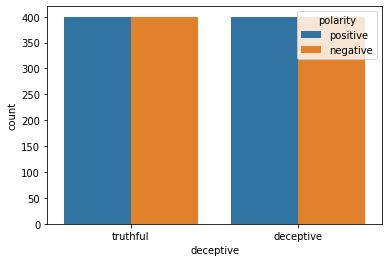

In [11]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

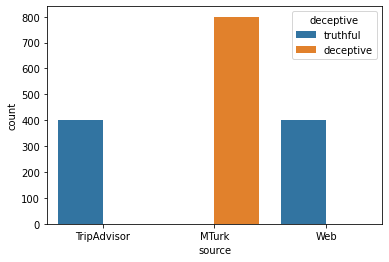

In [12]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [13]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [14]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [15]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroo..."
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, ..."
2,truthful,This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a...
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high lev..."
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were ..."


In [16]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [17]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroo..."
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, ..."
2,1,This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high lev..."
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were ..."


In [18]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [19]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroo...",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge...
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, ...",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing at...
2,1,This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a...,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high lev...",The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level...
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were ...",I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were ple...
5,1,I stayed at the Omni for one night following a business meeting at another downtown Chicago hotel. I was completely impressed by the service; all personnel during my stay were absolutely outstandi...,I stayed at the Omni for one night following a business meeting at another downtown Chicago hotel I was completely impressed by the service all personnel during my stay were absolutely outstanding...
6,1,We stayed in the Conrad for 4 nights just before Thanksgiving. We had a corner room overlooking N Michigan Av and the Tribune Building. To say this is a 5 star hotel is to damn this place with fai...,We stayed in the Conrad for nights just before Thanksgiving We had a corner room overlooking N Michigan Av and the Tribune Building To say this is a star hotel is to damn this place with faint pra...
7,1,Just got back from 2 days up in Chicago shopping with girlfriends. First time I have stayed at the Omni. I did so because I saw a $129.00 rate that included $25.00 of free food on Travelzoo. The t...,Just got back from days up in Chicago shopping with girlfriends First time I have stayed at the Omni I did so because I saw a rate that included of free food on Travelzoo The three of us all staye...
8,1,We arrived at the Omni on 2nd September for a 6 day stay. I took ill when I left the plane after travelling from Manchester so I saw more of the room than I anticipated. I couldn't go out for 4 da...,We arrived at the Omni on nd September for a day stay I took ill when I left the plane after travelling from Manchester so I saw more of the room than I anticipated I couldn t go out for days The ...
9,1,"On our visit to Chicago, we chose the Hyatt due to its location in downtown, within walking distance to most major attractions, such as Sears Tower, Magnificent Mile, Grant/Millenium Parks, etc. S...",On our visit to Chicago we chose the Hyatt due to its location in downtown within walking distance to most major attraction

In [20]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [21]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge...
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing at...
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level...
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were ple...


## MODEL BUILDING - (ROBERTA CLASSIFIER) Robustly Optimized BERT approach

RoBERTa (A Robustly Optimized BERT Pretraining Approach) BERT(Bidirectional Encoder Representations from Transformers) builds upon BERT by pretraining longer with more data, bigger batch sizes while only pretraining on masked language modeling as opposed to pretraining on next sentence prediction as well. 

In [22]:
import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

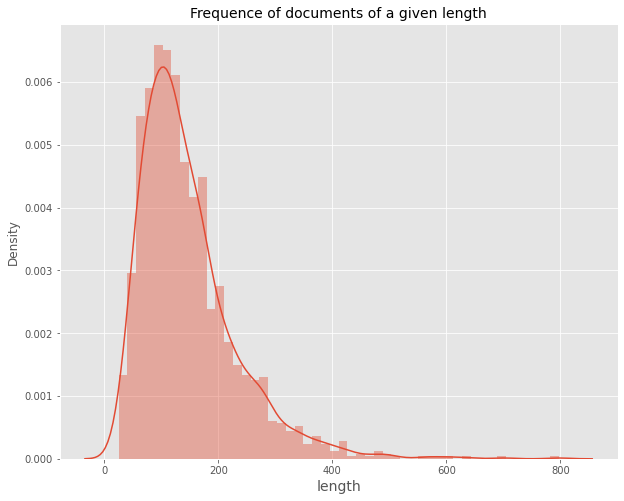

In [23]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['text'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [24]:
# cropped the data to max length of the model.
df['text'] = df['text'].apply(lambda x: " ".join(x.split()[:512]))
df['text']

0       We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge...
1       Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing at...
2       This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend...
3       The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level...
4       I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of 

In [25]:
df.to_csv('data.csv', index=False)

In [26]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [27]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [28]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [29]:
PAD_INDEX, UNK_INDEX

(1, 3)

In [30]:
# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'text' : ('text', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path=f"/content/data.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='label')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.text), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [31]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [32]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [33]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [34]:
output_path = '/content/output_path'

In [35]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [36]:
# Main training loop
NUM_EPOCHS = 10
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 30
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start pretraining ==============================
Epoch [1/10], global step [70/700], PT Loss: 0.7326, Val Loss: 0.6968
Epoch [2/10], global step [140/700], PT Loss: 0.7170, Val Loss: 0.6916
Epoch [3/10], global step [210/700], PT Loss: 0.7086, Val Loss: 0.6925
Epoch [4/10], global step [280/700], PT Loss: 0.6951, Val Loss: 0.6901
Epoch [5/10], global step [350/700], PT Loss: 0.6970, Val Loss: 0.6890
Epoch [6/10], global step [420/700], PT Loss: 0.6962, Val Loss: 0.6869
Epoch [7/10], global step [490/700], PT Loss: 0.6904, Val Loss: 0.6854
Epoch [8/10], global step [560/700], PT Loss: 0.6825, Val Loss: 0.6848
Epoch [9/10], global step [630/700], PT Loss: 0.7022, Val Loss: 0.6843
Epoch [10/10], global step [700/700], PT Loss: 0.6942, Val Loss: 0.6842
Pre-training done!
======================= Start training =================================
Epoch [1/30], global step [70/2100], Train Loss: 0.6994, Valid Loss: 0.6828
Epoch [2/30], global step [140/2100], Train Loss:

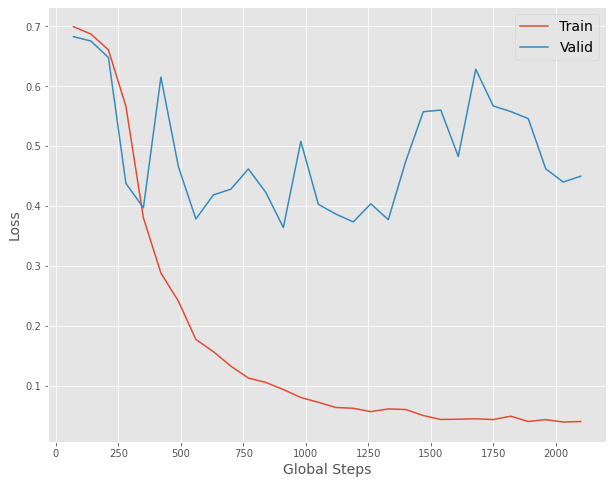

In [37]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [39]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

           1     0.9667    0.7250    0.8286       160
           0     0.7800    0.9750    0.8667       160

    accuracy                         0.8500       320
   macro avg     0.8733    0.8500    0.8476       320
weighted avg     0.8733    0.8500    0.8476       320



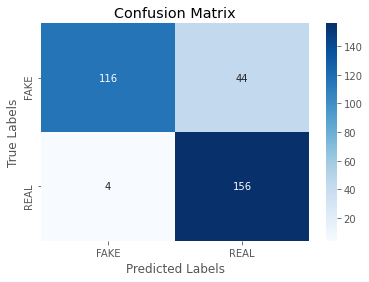

In [40]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)